# Classification trees

## Intro

Classification trees are one type of **decision tree** that can be used for predicting categorical outputs.
In the next notebook we will look at regression trees, which are used for making continuous predictions.

If you have ever played the game 21 questions then you already know what a classification tree is.
Or if you've ever tried to code up an artificial general intelligence using a lot of `if` statements, then you've essentially built up your own decision tree by hand.

These examples use the obvious approach of building a classifier by asking a series of yes/no questions.
The answer to each question gives you more info on class of the object until the range of possible options becomes fine enough for you to settle on a prediction.

Below is an example of such a classifier.
This one predicts the gender using the height and weight of an example person.

![](images/CARTS_example_tree.png)

The above examples however, depend on you finding the right questions to ask manually.
We'd like to be able to find the right questions to ask automatically, using machine learning.
This means that we need to start quantifying what makes a **good** split.

![](images/CARTS_geni_impurity.png)

![](images/CARTS_split_pos.png)

Let's build a classification tree from scratch. The first cell below just sets up some helper functions that we used previously.

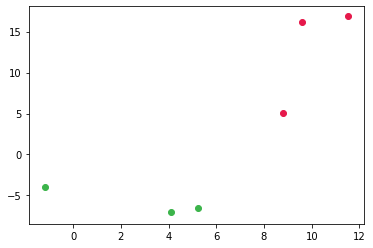

In [94]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn.datasets
from get_colors import colors

def get_data(sd=6, m=100, n_features=2, n_clusters=2):
    X, Y = sklearn.datasets.make_blobs(n_samples=m, n_features=n_features, centers=n_clusters, cluster_std=sd)
    return X, Y

def show_data(X, Y, predictions=None):
    for i in range(min(Y), max(Y)+1):
        y = Y == i
        x = X[y]
        plt.scatter(x[:, 0], x[:, 1], c=colors[i])
        if predictions is not None:
            y = predictions == i
            x = X[y]
            plt.scatter(x[:, 0], x[:, 1], c=colors[i], marker='x', s=100)
    plt.show()

def visualise_predictions(H, X, n=50):
    xmin, xmax, ymin, ymax = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
    meshgrid = np.zeros((n, n))
    for x1_idx, x1 in enumerate(np.linspace(xmin, xmax, n)): # for each column
        for x2_idx, x2 in enumerate(np.linspace(ymin, ymax, n)): # for each row
            h = H(np.array([[x1, x2]])).astype(int)[0]
            # plt.scatter(x1, x2, c=colors[h])
            # print(h)
            meshgrid[n-1-x2_idx, x1_idx] = h # axis 0 is the vertical direction starting from the top and increasing downward
        # print()

    # meshgrid[n-1, 0] = 1000
    plt.imshow(meshgrid, extent=(xmin, xmax, ymin, ymax), cmap='viridis')

m = 6
n_features = 2
n_classes = 2
X, Y = get_data(5, m, n_features, n_classes)
show_data(X, Y)

6
feature impurity: 0
feature impurity: 0.24
feature impurity: 0.1875
feature impurity: 0.24
feature impurity: 0
final impurity: 0
6
feature impurity: 0
feature impurity: 0.24
feature impurity: 0.1875
feature impurity: 0.1875
feature impurity: 0
final impurity: 0
3
feature impurity: 0
feature impurity: 0
final impurity: 0
3
feature impurity: 0
feature impurity: 0
final impurity: 0
1
final impurity: inf
1
final impurity: inf
2
feature impurity: 0
final impurity: 0
2
feature impurity: 0
final impurity: 0
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
3
feature impurity: 0
feature impurity: 0
final impurity: 0
3
feature impurity: 0
feature impurity: 0
final impurity: 0
2
feature impurity: 0
final impurity: 0
2
feature impurity: 0
final impurity: 0
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
1
final impurity: inf
{
    "split_impurity": 0,
    "feature_to_split_on": 0,
    "value_to_s

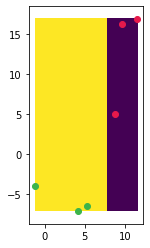

In [101]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class ClassificationTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def get_region_impurity(self, examples_in_region):
        x, Y = examples_in_region
        n_classes = np.ptp(Y)
        n_datapoints = len(x)
        impurity = 0
        for class_idx in range(n_classes):
            n_examples_in_class = len(x[Y == class_idx])
            p_k = n_examples_in_class / n_datapoints
            impurity += p_k * (1 - p_k)
        return impurity

    def get_split_impurity(self, x, Y, split_pos):
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        impurity = 0
        impurity += self.get_region_impurity(in_first_region)
        impurity += self.get_region_impurity(not_in_first_region)
        return impurity

    def get_split_candidates(self, x):
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        best_feature_to_split_on = None
        best_impurity = float('inf')
        best_split_pos = None
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_impurity = self.get_best_split_on_this_feature(x, Y)
            # print('feature impurity:', split_impurity)
            if split_impurity < best_impurity:
                best_split_pos = split_pos
                best_impurity = split_impurity
                best_feature_to_split_on = feature_idx
        # print('best_split_impurity:', best_impurity)
        return best_split_pos, best_impurity, best_feature_to_split_on

    def get_best_split_on_this_feature(self, x, Y):
        split_candidates = self.get_split_candidates(x)
        best_impurity = float('inf')
        best_split_pos = None
        for split_pos in split_candidates:
            impurity = self.get_split_impurity(x, Y, split_pos)
            if impurity < best_impurity:
                best_impurity = impurity
                best_split_pos = split_pos
        return best_split_pos, best_impurity

    def extend_tree(self, X, Y, depth=0):
        split_val, split_impurity, split_feature = self.get_best_split(X, Y)
        # tree['split'] 
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_impurity': 0, # so the split is pure
                'classification': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_impurity': split_impurity,
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'classification': np.mean(Y)})
        return new_branch

    def get_split(self, X, Y, tree):
        features = X[:, tree['split']['feature_to_split_on']]
        idxs = features > tree['split']['value_to_split_on']
        return (X[idxs], Y[idxs]), (X[np.logical_not(idxs)], Y[np.logical_not(idxs)])

    def fit(self, X, Y):
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        tree = self.tree
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            classified = False
            while classified == False:
                if x[tree['feature_to_split_on']] > tree['value_to_split_on']:
                    tree = copy.deepcopy(tree['positive_branch'])
                else: 
                    tree = tree['negative_branch']
                if 'positive_branch' not in tree.keys():
                    classified = True
                    classifications[idx] = tree['classification']
        # print(classifications[:10])
        # print(classifications[-1])
        # print(np.mean(classifications))
        return classifications

    def __repr__(self):
        return json.dumps(self.tree, indent=4)

classificationTree = ClassificationTree(max_depth=60)
classificationTree.fit(X, Y)
visualise_predictions(classificationTree.predict, X)
print(classificationTree)
show_data(X, Y)
